In [133]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random

from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid


import PCA_functions as pf
import Extreme_functions as ef

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from Data import Data
from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import itertools
from collections import Counter
import pickle

from numpy import linalg as LA

import matplotlib.cm as cm

from scipy.special import inv_boxcox
from scipy import stats

from matplotlib import animation

import scipy.stats as st

import reverse_geocoder as rg

from pandas_datareader import wb
import scipy.stats as st

import Rung as rung

from pandas_datareader import wb

import seaborn as sns


import seaborn as sns
import feature_finder_keiko as ff
import feature_finder_f as ff1

from scipy import signal

plt.rcParams["figure.figsize"] = (20,10)

In [134]:
def model_generator_V(count, data_sst, link, V, tau, ratio = 0.8, n_estimators=100, max_depth=5):
    
    start_lag = tau
    end_lag = tau+11
    
    df = pd.DataFrame({"drought":count})
    df = ff.shift_df(df, start_lag, end_lag)
    x_train = df.iloc[:,1:]
    y_train = df.iloc[:,0]
    base_model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    base_model.fit(x_train, y_train)        
            
    df = pd.DataFrame({"drought": count})
    lags = np.arange(start_lag,end_lag + 1)
    df = df.assign(**{
    '{} (t-{})'.format(col, t): df[col].shift(t)
    for t in lags
    for col in df
    })
    for k in range(len(link)):
        df[str(k)] = ff.time_series_maker_V(data_sst, V[:,link[k,0]-1])
        df[str(k)] = df[str(k)].shift(abs(link[k,1]))
    df = df.dropna()
        
    x_train = df.iloc[:,1:]
    y_train = df.iloc[:,0]
    model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    model.fit(x_train, y_train)
        
    return(base_model, model, x_train)

In [144]:
def model_generator_no_base(count, data_sst, link, V, tau, ratio = 0.8, n_estimators=100, max_depth=5):
    
    start_lag = tau
    end_lag = tau+11
    
    df = pd.DataFrame({"drought":count})
    df = ff.shift_df(df, start_lag, end_lag)
    x_train = df.iloc[:,1:]
    y_train = df.iloc[:,0]
    base_model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    base_model.fit(x_train, y_train)        
            
    df = pd.DataFrame({"drought":count})
    for k in range(len(link)):
        df[str(k)] = ff.time_series_maker_V(data_sst, V[:,link[k,0]-1])
        df[str(k)] = df[str(k)].shift(abs(link[k,1]))
    df = df.dropna()
        
    x_train = df.iloc[:,1:]
    y_train = df.iloc[:,0]
    model = RandomForestRegressor(max_depth=max_depth, random_state=0, n_estimators=n_estimators)
    model.fit(x_train, y_train)
        
    return(base_model, model, x_train)

In [145]:
def test_data_generator(count, data_sst, link, tau, df_sst, V):
    start_lag = tau
    end_lag = tau + 11

    df_test = pd.DataFrame({"drought":count})
    lags = np.arange(start_lag,end_lag + 1)
    df_test = df_test.assign(**{
    '{} (t-{})'.format(col, t): df_test[col].shift(t)
    for t in lags
    for col in df_test
    })
    
    for k in range(len(link)):
        df_sst["pc"] = V[:,link[k,0]-1]
        df_test[str(k)] = ff.time_series_maker(link[k,0]-1, df_sst, data_sst)
        df_test[str(k)] = df_test[str(k)].shift(abs(link[k,1]))
    df_test = df_test.dropna()

    x_test = df_test.iloc[:,1:]
    y_test = df_test.iloc[:,0]
    return(x_test, y_test)

In [146]:
def test_data_generator_no_base(count, data_sst, link, tau, df_sst, V):
    start_lag = tau
    end_lag = tau + 11

    df_test = pd.DataFrame({"drought":count})
    
    for k in range(len(link)):
        df_sst["pc"] = V[:,link[k,0]-1]
        df_test[str(k)] = ff.time_series_maker(link[k,0]-1, df_sst, data_sst)
        df_test[str(k)] = df_test[str(k)].shift(abs(link[k,1]))
    df_test = df_test.dropna()

    x_test = df_test.iloc[:,1:]
    y_test = df_test.iloc[:,0]
    return(x_test, y_test)

In [147]:
train_start = 1930
validation_end = 2000

n_components_sst = 98

temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(validation_end, 12, 1, 0, 0)}
original_count, count = ff.drought_timeseries("../npy_files/ET_gamma_18912015.npy",train_start,validation_end)
data_sst, ts, V, df_sst, avg, std = ff.PCA_computer_rotated('../../../nc/sst.mnmean.nc', "sst",temporal_limits, n_components_sst, -9.96921e+36)

test_start = 2001
test_end = 2015

temporal_limits_test = {"time_min":datetime(test_start, 1, 1, 0, 0),"time_max":datetime(test_end, 12, 1, 0, 0)}
data_sst_test = ff.data_generator_avg_std('../../../nc/sst.mnmean.nc', "sst",temporal_limits_test, avg, std, 12, -9.96921e+36)
original_count_test, count_test = ff.drought_timeseries("../npy_files/ET_gamma_18912015.npy",test_start,test_end)

In [119]:
tau = 3

In [120]:
link_caus = np.load("../../whole_data_results/link_rotated_ET/best_link_all_1930_2000_{}.npy".format(tau))
link_corr = np.load("../../whole_data_results/link_rotated_ET/best_link_all_corr_1930_2000_{}.npy".format(tau))

In [131]:
base_caus, model_caus, x_train= model_generator_V(original_count, data_sst, link_caus, V, tau)

In [132]:
x_test, y_test = test_data_generator(original_count_test, data_sst_test, link_caus, tau, df_sst, V)

In [123]:
y_pred = model_caus.predict(x_test)

In [124]:
math.sqrt(mean_squared_error(y_pred, y_test))

39.6902911742051

In [125]:
x = np.arange(len(y_pred))

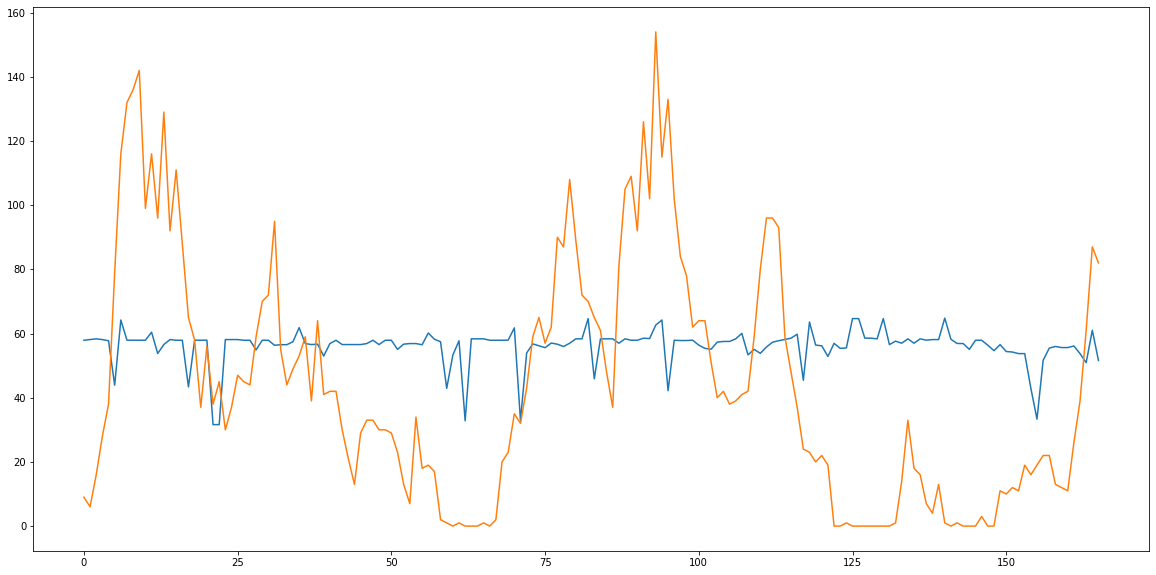

In [126]:
plt.plot(x, y_pred, x, y_test)

In [127]:
lags = np.arange(-tau,-tau - 12,-1)

In [128]:
c = np.ones(12)
c = c.astype(int)
#c = c*2

In [107]:
link = np.vstack((c,lags)).T

In [129]:
base_caus, model_caus, x_train= model_generator_no_base(original_count, data_sst, link, V, tau)

x_test, y_test = test_data_generator_no_base(original_count_test, data_sst_test, link, tau, df_sst, V)

y_pred = model_caus.predict(x_test)

math.sqrt(mean_squared_error(y_pred, y_test))

39.54056297367159

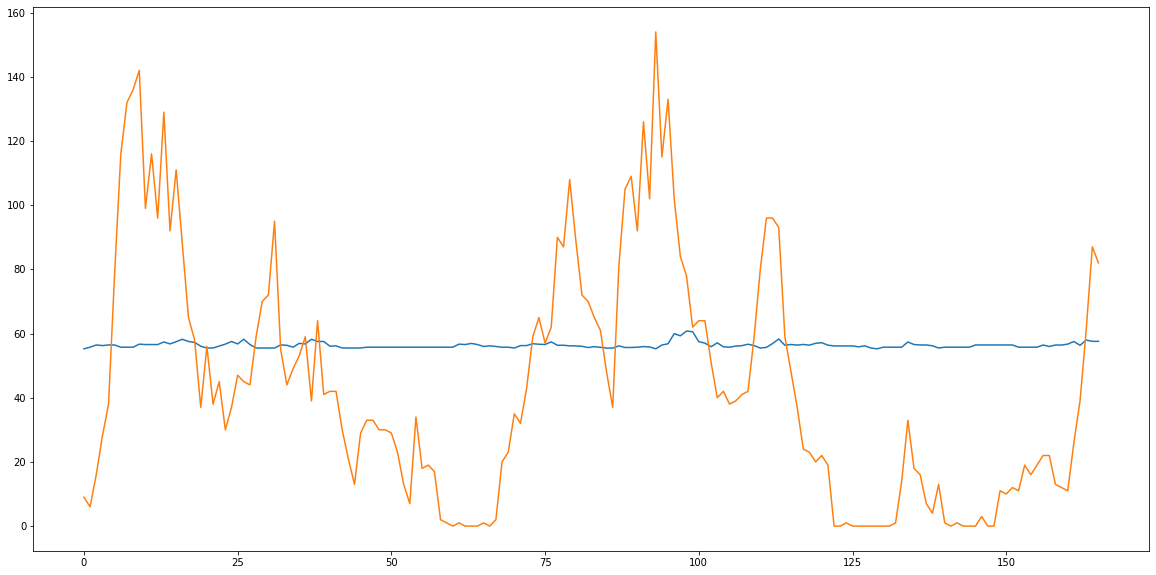

In [130]:
x = np.arange(len(y_pred))

plt.plot(x, y_pred, x, y_test)

# Class

In [156]:
class_name = "BSh"

tau = 3

link_caus = np.load("../../whole_data_results/link_rotated_ET/best_link_all_1930_2000_{}_{}.npy".format(tau, class_name))
link_corr = np.load("../../whole_data_results/link_rotated_ET/best_link_corr_all_1930_2000_{}_{}.npy".format(tau, class_name))


In [152]:
class_list = np.load("../npy_files/ET_class_list.npy")
index = (np.array(class_list) == class_name)

In [153]:
train_start = 1930
validation_end = 2000

n_components_sst = 98

temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(validation_end, 12, 1, 0, 0)}
original_count, count = ff.drought_timeseries_class("../npy_files/ET_gamma_18912015.npy",index,train_start,validation_end)
data_sst, ts, V, df_sst, avg, std = ff.PCA_computer_rotated('../../../nc/sst.mnmean.nc', "sst",temporal_limits, n_components_sst, -9.96921e+36)

test_start = 2001
test_end = 2015

temporal_limits_test = {"time_min":datetime(test_start, 1, 1, 0, 0),"time_max":datetime(test_end, 12, 1, 0, 0)}
data_sst_test = ff.data_generator_avg_std('../../../nc/sst.mnmean.nc', "sst",temporal_limits_test, avg, std, 12, -9.96921e+36)
original_count_test, count_test = ff.drought_timeseries_class("../npy_files/ET_gamma_18912015.npy",index,test_start,test_end)

In [161]:
base_caus, model_caus, x_train= model_generator_V(original_count, data_sst, link_caus, V, tau)

x_test, y_test = test_data_generator(original_count_test, data_sst_test, link_caus, tau, df_sst, V)

y_pred = model_caus.predict(x_test)

math.sqrt(mean_squared_error(y_pred, y_test))

7.141043580069037

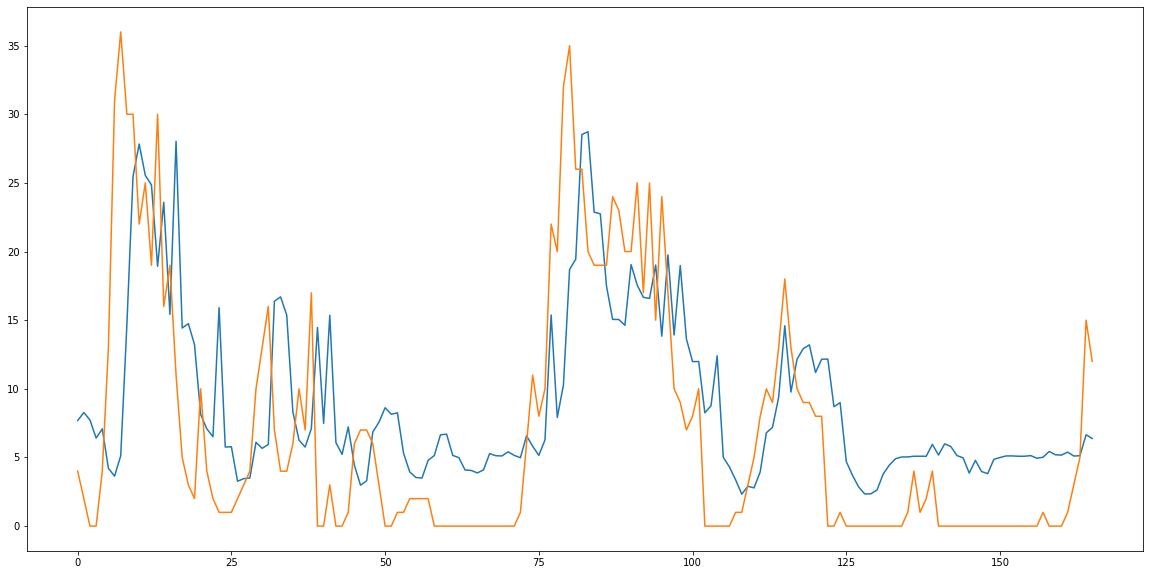

In [168]:
x = np.arange(len(y_pred))

plt.plot(x, y_pred, x, y_test)

In [167]:
lags = np.arange(-tau,-tau - 12,-1)

c = np.ones(12)
c = c.astype(int)
#c = c*2

link = np.vstack((c,lags)).T

base_caus, model_caus, x_train= model_generator_V(original_count, data_sst, link, V, tau)

x_test, y_test = test_data_generator(original_count_test, data_sst_test, link, tau, df_sst, V)

y_pred = model_caus.predict(x_test)

math.sqrt(mean_squared_error(y_pred, y_test))

7.201446285750309